#### 数据集
Geolife GPS trajectory dataset
#### idea
聚类得出每类的代表性轨迹，而后计算每条轨迹与其的距离差与时间差（二者看看用什么函数），将距离矩阵投入 Prophet中预测
##### TODO_List
- [x] 聚类（时间差与距离）
- [x] 轨迹平滑处理
   - [x] 代码测试通过
   - [x] 寻找最佳参数--------除了I外的个元素越大越平滑
- [x] 代表性的轨迹
   - [x] 聚类中心--- clusters.centroids[clustersIndex][:,0],clusters.centroids[clustersIndex][:,1]
   - [ ] 轨迹点数目的归一化----Ramer-Douglas-Peucker Algorithm
    - [ ] 归一化参数选择，确保都是一样数目的点
- [ ] Prophet 使用
   - [ ] 距离矩阵的计算

##### 算法框架
1.  将原始轨迹按 ID 读入内存中，卡尔曼滤波后再进行计算
2.  进行QuickBundles聚类，得出聚类中心线
3.  每类中的所有轨迹与其中心线的距离矩阵的计算
4.  将距离矩阵 + 具体时间点投入Prophet中，注意每个 ID 可能会对应多个预测模型，但每个类仅对应一个预测模型
5.  调参

In [1]:
from dipy.tracking.streamlinespeed import Streamlines
%matplotlib inline
# 数据处理
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
from gmplot import gmplot
from tqdm import tqdm
# Enable inline plotting

names = ['lat','lng','zero','alt','days','date','time']
streams = []
TimeStamp = []
index = 0

userdata = 'data\\Geolife Trajectories 1.3\\Data\\' + '001' + '\\Trajectory\\'
filelist = os.listdir(userdata)

for f in tqdm(filelist):
    df_list = [pd.read_csv(userdata + f,header=6,names=names,index_col=False, parse_dates=[['date', 'time']])]
    df = pd.concat(df_list, ignore_index=True)
    df.drop(['zero','alt','days'], axis=1, inplace=True)
    df.set_index('date_time')
    df_min = df
    time_h = (df.date_time - dt.datetime(2008,10,23,9,9,9)).map(lambda x: x/np.timedelta64(1,'s'))
    # df_min = df.iloc[::12, :, :]
    # pd.to_datetime(df_min['date_time'], format='%Y-%m-%d %H:%M:%S')
    # timedelta = abs(df_min.date_time - dt.datetime(2008,11,11,9,9,9,9))
    lat_lng_data = np.c_[df_min['lat'].values, df_min['lng'].values, time_h]
    streams.append(lat_lng_data)


print(streams[0][0,0], streams[0][0,1], streams[0][0,2])
gmap = gmplot.GoogleMapPlotter(streams[0][0,0], streams[0][0,1], 12)
# Time_Streams = dict(zip(TimeStamp, streams))
# print(Time_Streams['2008-10-23 05:53:05'])
for i in range(len(streams)):
    gmap.plot(streams[i][:,0], streams[i][:,1], 'cornflowerblue', edge_width=1)


gmap.draw("user001_map.html")


100%|██████████| 71/71 [00:02<00:00, 24.30it/s]


39.984198 116.319322 -11763.0


In [2]:
# 分类
import geopy.distance
from dipy.segment.metric import Metric
from dipy.segment.metric import ResampleFeature
import numpy as np
from dipy.segment.clustering import QuickBundles
THRESHOLD = 1
class GPSDistance(Metric):
    def __init__(self):
        super(GPSDistance, self).__init__(feature=ResampleFeature(nb_points=256))

    def are_compatible(self, shape1, shape2):
        return len(shape1) == len(shape2)

    def dist(self, v1, v2):
        x = [geopy.distance.distance([p[0][0], p[0][1]], [p[1][0], p[1][1]]).kilometers  for p in list(zip(v1, v2)) if p[0][2] - p[1][2] < 10]
        currD = np.mean(x)
        return currD


metric = GPSDistance()
qb = QuickBundles(threshold=THRESHOLD, metric=metric)

clusters = qb.cluster(streams)
print("Nb. clusters:", len(clusters))

Nb. clusters: 18


In [ ]:
# 画图 1
from gmplot import gmplot
import random

def randomcolor():
    colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
    color = ""
    for i in range(6):
        color += colorArr[random.randint(0,14)]
    return "#"+color

gmap = gmplot.GoogleMapPlotter(streams[0][0,0], streams[0][0,1], 12)

for clustersIndex in range(len(clusters)):
    color = randomcolor()
    for i in clusters[clustersIndex].indices:
        gmap.plot(streams[i][:,0], streams[i][:,1], color, edge_width=1)

gmap.draw("user001_map.html")
print('done')

In [ ]:
# 画图 2
from matplotlib import rcParams
rcParams['figure.facecolor']=(1,1,1,1)
for i in range(len(clusters)):
     for j in clusters[i].indices:
        plt.plot(streams[i][:,0], streams[i][:,1]) # Plot some data on the (implicit) axes.

plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title("Simple Plot")
plt.legend()

## -------------------------以上为聚类代码-----------------------------

In [ ]:
from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt
import time
from gmplot import gmplot
import random


def randomcolor():
    colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
    color = ""
    for k in range(6):
        color += colorArr[random.randint(0,14)]
    return "#"+color

def func_kalman_1(array):
    measurements = array

    initial_state_mean = [measurements[0, 0],
                      0,
                      measurements[0, 1],
                      0]

    transition_matrix = [[1, 1, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 1],
                     [0, 0, 0, 1]]

    observation_matrix = [[1, 0, 0, 0],
                      [0, 0, 1, 0]]

    kf1 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean)

    kf1 = kf1.em(measurements, n_iter=5)
    (smoothed_state_means, smoothed_state_covariances) = kf1.smooth(measurements)

def func_kalman_2(array):
    measurements = array

    initial_state_mean = [measurements[0, 0],
                      0,
                      measurements[0, 1],
                      0]

    transition_matrix = [[1, 1, 0, 0],
                         [0, 1, 0, 0],
                         [0, 0, 1, 1],
                         [0, 0, 0, 1]]

    observation_matrix = [[1, 0, 0, 0],
                          [0, 0, 1, 0]]

    kf1 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean)

    kf2 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean,
                  observation_covariance = 10*kf1.observation_covariance,
                  em_vars=['transition_covariance', 'initial_state_covariance'])

    kf2 = kf2.em(measurements, n_iter=5)
    (smoothed_state_means, smoothed_state_covariances)  = kf2.smooth(measurements)

    gmap = gmplot.GoogleMapPlotter(streams[0][0,0], streams[0][0,1], 12)

    color1 = randomcolor()
    # color2 = randomcolor()
    # gmap.plot(measurements[:,0], measurements[:,1], 'white', edge_width=1)
    gmap.plot(smoothed_state_means[:,0], smoothed_state_means[:,2], color1, edge_width=1)


## --------------以上为kalman 滤波（轨迹平滑）代码-------------------


In [ ]:
# 组轨迹求均值
from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt
import time
import tqdm
from gmplot import gmplot
import random
iter = 20
def randomcolor():
    colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
    color = ""
    for k in range(6):
        color += colorArr[random.randint(0,14)]
    return "#"+color

def tolerant_mean(arrs):
    lens = [j.shape[0] for j in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1)

def func_kalman_1(array):
    measurements = streams[5]

    initial_state_mean = [measurements[0, 0],
                      0,
                      measurements[0, 1],
                      0]

    transition_matrix = [[1, 1, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 1],
                     [0, 0, 0, 1]]

    observation_matrix = [[1, 0, 0, 0],
                      [0, 0, 1, 0]]

    kf1 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean)

    kf1 = kf1.em(measurements, n_iter=5)
    (smoothed_state_means, smoothed_state_covariances) = kf1.smooth(measurements)

def func_kalman_2(array):
    measurements = array

    initial_state_mean = [measurements[0, 0],
                      0,
                      measurements[0, 1],
                      0]

    transition_matrix = [[1, 6, 0, 0],
                         [0, 1, 0, 0],
                         [0, 0, 1, 6],
                         [0, 0, 0, 1]]

    observation_matrix = [[1 ,0, 0, 0],
                          [0, 0, 1, 0]]

    kf1 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean)
    kf1 = kf1.em(measurements, n_iter=iter)
    (smoothed_state_means, smoothed_state_covariances) = kf1.smooth(measurements)
    kf2 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean,
                  observation_covariance = 20*kf1.observation_covariance,
                  em_vars=['transition_covariance', 'initial_state_covariance'])

    kf2 = kf2.em(measurements, n_iter=iter)
    (smoothed_state_means, smoothed_state_covariances)  = kf2.smooth(measurements)
    return smoothed_state_means, measurements


gmap =gmplot.GoogleMapPlotter(streams[0][0,0], streams[0][0,1], 12)

# for clustersIndex in tqdm.trange(len(clusters)):
#     color = randomcolor()
#     lat_list = []
#     lng_list = []
    # 计算平均轨迹
for i in tqdm.tqdm(clusters[0].indices):
        # lat_list.append(streams[i][:,0])
        # lng_list.append(streams[i][:,1])
    x = [streams[i][:,0],streams[i][:,1]]
    x = np.array(x).T
    # x = [tolerant_mean(lat_list), tolerant_mean(lng_list)]
    # x = np.array(x).T
    # print(x.shape)
    # gmap.plot(x[0], x[1], color, edge_width=1)
    smooth , measurements= func_kalman_2(x)
    print(smooth[0,0], smooth[0,2])


    color1 = randomcolor()
    # color2 = randomcolor()
    gmap.plot(measurements[:,0], measurements[:,1], 'white', edge_width=1)
    gmap.plot(smooth[:,0], smooth[:,2], color1, edge_width=1)

gmap.draw("user001_map.html")
print("done")


## --------- 以上为提取平均轨迹+kalman滤波 ------------



In [ ]:
# 画图
from gmplot import gmplot
import random

def randomcolor():
    colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
    color = ""
    for i in range(6):
        color += colorArr[random.randint(0,14)]
    return "#"+color

gmap = gmplot.GoogleMapPlotter(streams[0][0,0], streams[0][0,1], 12)

for clustersIndex in range(len(clusters)):
    color = randomcolor()
    for i in clusters[clustersIndex].indices:
        print(i)
        gmap.plot(streams[i][:,0], streams[i][:,1], color, edge_width=1)
        break

gmap.draw("user001_map.html")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
from matplotlib import rcParams
rcParams['figure.facecolor']=(1,1,1,1)
np.random.seed(10) # 固定随机数种子
import shapely
# 创建线
line = shapely.geometry.LineString(np.array([streams[0][:,0], streams[0][:,1]]).T)

# 绘制简化前
ax = gpd.GeoSeries([line]).plot(color='red')

# 绘制简化后
ax = gpd.GeoSeries([line]).simplify(tolerance=0.0017).plot(color='blue',
                                                        ax=ax,
                                                        linestyle='--')

# 制作图例映射对象列表
LegendElement = [plt.Line2D([], [], color='red', label='Before'),
                 plt.Line2D([], [], color='blue', linestyle='--', label='After')]

# 将制作好的图例映射对象列表导入legend()中，并配置相关参数
ax.legend(handles = LegendElement,
          loc='lower left',
          fontsize=10)


ax.axis('off')

In [ ]:
# !!!!!!! 聚类中心代码
from gmplot import gmplot
import random

def randomcolor():
    colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
    color = ""
    for i in range(6):
        color += colorArr[random.randint(0,14)]
    return "#"+color

gmap = gmplot.GoogleMapPlotter(streams[0][0,0], streams[0][0,1], 12)

for clustersIndex in range(len(clusters)):
    color = randomcolor()
    gmap.plot(clusters.centroids[clustersIndex][:,0], clusters.centroids[clustersIndex][:,1], color, edge_width=1)
    # for i in clusters[clustersIndex].indices:
    #     gmap.plot(streams[i][:,0], streams[i][:,1], color, edge_width=1)
gmap.draw("user001_map.html")
print('done')

## ----------------以上为聚类中心代码-----------------

In [ ]:
from rdp import rdp
index = 1
mask = rdp(streams[index], epsilon=0.0001 ,algo="iter")
gmap = gmplot.GoogleMapPlotter(streams[index][0,0], streams[index][0,1], 12)
gmap.plot(streams[index][:,0], streams[index][:,1], 'yellow', edge_width=1.5)
gmap.plot(mask[:,0], mask[:,1], 'cornflowerblue', edge_width=1)
print(streams[index].shape)
print(mask.shape)
gmap.draw("user001_map.html")
print('done')




In [ ]:
from scipy import spatial
import matplotlib.pyplot as plt
from matplotlib import rcParams
import tqdm
print("#0 clusters:", clusters[0].indices)
print("#1 clusters:", clusters[3].indices)
distance_0_0 = []
distance_0_1 = []

for i in tqdm.tqdm(clusters[0].indices):
    var ,_, _= spatial.distance.directed_hausdorff(clusters.centroids[0], streams[i])
    distance_0_0.append(var)

for j in tqdm.tqdm(clusters[3].indices):
    var ,_, _= spatial.distance.directed_hausdorff(clusters.centroids[0], streams[j])
    distance_0_1.append(var)

rcParams['figure.facecolor']=(1,1,1,1)
plt.plot(distance_0_0, distance_0_0, 'bs', distance_0_1, distance_0_1, 'g^')


In [ ]:
a = np.zeros((1,),dtype=int)
array = np.random.randint(1,10,size=59)


for i in range(len(clusters)):
    print(len(clusters[i]))

list = clusters.get_small_clusters(1)
print(list)
print(type(list))
print(len(streams))
for i in list:
    print(i.indices[0])
    # a.append(i.indices[0])
    a = np.append(a,i.indices[0])
a = np.delete(a,0,axis=0)
# mask = [i for i in range(len(array)) if i in a]
a

# for index in list:
#     clusters.remove_cluster(index)
#
# for i in range(len(clusters)):
#     print(len(clusters[i]))

# d for d, s in zip(data, selectors) if s
a = [ 2,  3,  8, 14, 24, 25, 26, 34, 35, 42, 54, 61, 63]
array = np.random.randint(1,10,size=59)
mask = [i for i in range(len(array)) if i not in a]
mask

In [3]:
from tqdm import tqdm
Keep_Streams = []
mask = clusters > 2
for index in tqdm(range(len(clusters))):
    if mask[index]:
        for i in clusters[index].indices:
            Keep_Streams.append(streams[i])


100%|██████████| 18/18 [00:00<00:00, 3007.51it/s]


71
0
30
33
52
69
1
7
10
12
13
19
22
29
50
55
56
57
66
4
5
11
15
16
21
31
47
49
53
58
67
68
6
9
17
18
20
23
27
32
36
38
40
41
43
44
45
46
48
51
59
60
62
64
65
70
28
37
39
58


In [4]:
# 双 聚类 代码
import geopy.distance
from dipy.segment.metric import Metric
from dipy.segment.metric import ResampleFeature
import numpy as np
from dipy.segment.clustering import QuickBundles
from tqdm import tqdm

Min_Trajectory_Number = 2

# 第一次聚类（低threshold 聚多类, 除去离群轨迹)
THRESHOLD_1 = 1

class GPSDistance(Metric):
    def __init__(self):
        super(GPSDistance, self).__init__(feature=ResampleFeature(nb_points=256))

    def are_compatible(self, shape1, shape2):
        return len(shape1) == len(shape2)

    def dist(self, v1, v2):
        x = [geopy.distance.distance([p[0][0], p[0][1]], [p[1][0], p[1][1]]).kilometers  for p in list(zip(v1, v2)) if p[0][2] - p[1][2] < 10]
        currD = np.mean(x)
        return currD

metric = GPSDistance()
qb = QuickBundles(threshold=THRESHOLD_1, metric=metric)

clusters = qb.cluster(streams)
print("First Nb. clusters:", len(clusters))

# 去除离群轨迹
Keep_Streams = []
mask = clusters > Min_Trajectory_Number
for index in tqdm(range(len(clusters))):
    if mask[index]:
        for i in clusters[index].indices:
            Keep_Streams.append(streams[i])

THRESHOLD_2 = 3.5
qb = QuickBundles(threshold=THRESHOLD_2, metric=metric)

clusters = qb.cluster(Keep_Streams)
print("Second Nb. clusters:", len(clusters))

100%|██████████| 18/18 [00:00<00:00, 18065.92it/s]
E:\Anaconda\envs\pytorch\lib\site-packages\numpy\core\fromnumeric.py:3256: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\envs\pytorch\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


First Nb. clusters: 18
Second Nb. clusters: 5


No handles with labels found to put in legend.


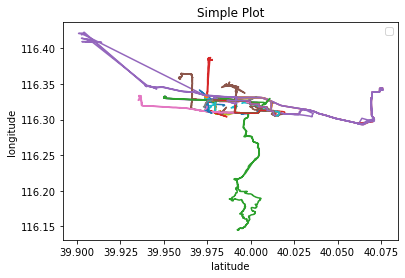

In [5]:
from matplotlib import rcParams
rcParams['figure.facecolor']=(1,1,1,1)
for i in range(len(clusters)):
     for j in clusters[i].indices:
        plt.plot(streams[j][:,0], streams[j][:,1]) # Plot some data on the (implicit) axes.

plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title("Simple Plot")
plt.legend()


In [ ]:
import time
userdata = 'data\\Geolife Trajectories 1.3\\Data\\' + '001' + '\\Trajectory\\'
filelist = os.listdir(userdata)

for f in tqdm(filelist):
    df_list = [pd.read_csv(userdata + f,header=6,names=names,index_col=False, parse_dates=[['date', 'time']])]
    df = pd.concat(df_list, ignore_index=True)
    df.drop(['zero','alt','days'], axis=1, inplace=True)
    df.set_index('date_time')
    df_min = df
    df_min['date_time'] = df_min['date_time'].apply(lambda x:time.mktime(x.timetuple())) # 所以最重要的是  日期.timetuple() 这个用法 通过它将日期转换成时间元组
    # print(df_min.head(10))
    print(df_min['date_time'].apply(lambda x:time.strftime('%Y/%m/%d %H:%M:%S',time.localtime(x))))



In [ ]:
###缩减点规模

from rdp import rdp
index = 1
mask = rdp(streams_work[index], epsilon=0.0001 ,algo="iter")
gmap = gmplot.GoogleMapPlotter(streams_work[index][0,0], streams_work[index][0,1], 12)
gmap.plot(streams_work[index][:,0], streams_work[index][:,1], 'yellow', edge_width=1.5)
gmap.plot(mask[:,0], mask[:,1], 'cornflowerblue', edge_width=1)
print(streams_work[index].shape)
print(mask.shape)
gmap.draw("user001_map.html")
print('done')